In [3]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import time
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [4]:
order=1

# NTURN = [128,256,512,1024,1024*2]#,1024*4]
# MU = [0.0,0.01,0.02,0.03,0.04,0.05,0.06]
NTURN = [1024,1024*2]
MU = [0.01]
# NU = [0.30345]
# NU = [0.3]
NU = [0.28, 0.3, 0.32, 0.34, 0.36]
TAU = [0.4]

nCore_y = 4
nCore_z = 4

NL_c = 0.01
NL_L = 1.8

npt=7668

pipe_radius = 0.02*np.sqrt(2.0)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [5]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [6]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
        
ElemNL = lattice[1]         
ElemNL.n_sckick = 100
ElemNL.length = NL_L
ElemNL.transverse_scale_c = NL_c
ElemNL.pipe_radius = 0.02*np.sqrt(2)

ElemM = lattice[2]
ElemM.nonlinear_insert_length = NL_L

In [7]:
ElemTBT = impact.getElem('TBT')
ElemTBT.pID_begin = 1
ElemTBT.pID_end = npt
lattice.insert(1,ElemTBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.format_id = 2
lattice.append(OUTPUT)

In [8]:
lattice[2]


             length: 1.8 [m]
           n_sckick: 100 [1]
              n_map: 10 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 0.028284271247461905 [m]
       tune_advance: 0.3034496449165134
               type: 'nonlinear_insert'

In [9]:
latticeB = copy(lattice[1:-1][::-1])
latticeB.insert(0,copy(lattice[0]))

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        ElemM_B = latticeB[i]
        ElemM_B.nonlinear_insert_length = -NL_L
    elif latticeB[i].type == 'nonlinear_insert':
        ElemNL_B = latticeB[i]

In [10]:
def normalize(data,alfx,betx):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data,alfx,betx):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

### 1.2. generate particles

In [11]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
print(len(pTest))

7668


In [12]:
def run(tau,nu,mu):
    alfx = np.tan(np.pi*nu)
    betx = NL_L/np.sin(2.0*np.pi*nu)
    pData = copy(pTest)
    unnormalize(pData,alfx,betx)
    impact.writeParticleData(pData, ke, mass, freq)
    
    lattice[0].turns = NTURN[0]
    ElemNL.strength_t = tau
    ElemNL.tune_advance = nu
    ElemM.tune_advance_x = mu
    ElemM.tune_advance_y = mu
    ElemM.nonlinear_insert_tuneAdvance = nu
    ElemTBT.file_id = NTURN[0]
    OUTPUT.file_id = NTURN[0]
    OUTPUT.turn = NTURN[0]
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeInputFile(beam,lattice) 
    impact.run(beam,order=order)
    for nturn in NTURN[:-1]:
        lattice[0].turns = nturn
        ElemTBT.file_id = nturn*2
        OUTPUT.turn = nturn
        OUTPUT.file_id = nturn*2
        beam.distribution.distribution_type = 'ReadFile_binary'
        beam.distribution.file_id = nturn
        impact.writeInputFile(beam,lattice) 
        impact.run(beam,order=order)
        
        
    ElemNL_B.strength_t = tau
    ElemNL_B.tune_advance = nu
    ElemM_B.tune_advance_x               =-mu
    ElemM_B.tune_advance_y               =-mu
    ElemM_B.nonlinear_insert_tuneAdvance =-nu
    for nturn in NTURN[:-1]:
        latticeB[0].turns = nturn
        latticeB[-1].file_id = 100000+nturn
        beam.distribution.distribution_type = 'ReadFile_binary'
        beam.distribution.file_id = nturn
        impact.writeInputFile(beam,latticeB) 
        impact.run(beam,order=order)

In [13]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)


def getData(tau,nu,mu):
    alfx = np.tan(np.pi*nu)
    betx = NL_L/np.sin(2.0*np.pi*nu)
    iTBT = {}
    TBT = {}
    Npt = {}
    
    for nturn in NTURN[:-1]:
        print(nturn)
        time.sleep(1)
        iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn,ke,mass,freq)
        TBT[-nturn] = TBT[-nturn][::-1,:4,:]
        Npt[-nturn] = len(iTBT[-nturn])
    # read TBT data
    for nturn in NTURN:
        print(nturn)
        time.sleep(1)
        iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
        TBT[nturn] = TBT[nturn][:,:4,:]
        Npt[nturn] = len(iTBT[nturn])



        
    # normalize TBT data
    XF = {}
    YF = {}
    for i in range(len(NTURN)):
        nturn = NTURN[i]
        npt = len(iTBT[nturn])
        XF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        YF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[nturn])
            tmp = TBT[jturn][:,:,itmp]
            XF[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            YF[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
            iturn = jturn
    XB = {}
    YB = {}
    for i in range(len(NTURN)-1):
        nturn = NTURN[i]
        npt = len(iTBT[-nturn])
        XB[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        YB[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        tmp = TBT[-nturn]
        XB[-nturn]=(tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        YB[-nturn]=(tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[-nturn])
            tmp = TBT[jturn][:,:,itmp]
            XB[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            YB[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
            iturn = jturn

            
    #FD
    tuneXbefore= {}
    tuneYbefore= {}
    Xdiff = {}
    Ydiff = {}
    Adiff = {}
    for nturn in NTURN[:-1]:
        nturn2 = 2*nturn
        npt = len(XF[nturn2][0,:])
        tuneXbefore[nturn] = np.zeros(npt)
        tuneYbefore[nturn] = np.zeros(npt)
        Xdiff[nturn] = np.zeros(npt)
        Ydiff[nturn] = np.zeros(npt)
        Adiff[nturn] = np.zeros(npt)
        for i in range(npt):
            signal = XF[nturn2][:nturn,i] -np.mean(XF[nturn2][:nturn,i])
            tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = XF[nturn2][nturn:,i] -np.mean(XF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
            signal = YF[nturn2][:nturn,i] -np.mean(YF[nturn2][:nturn,i])
            tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = YF[nturn2][nturn:,i] -np.mean(YF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)

        Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
#         print(np.min(Adiff[nturn]),np.max(Adiff[nturn]),np.sum(np.isnan(Adiff[nturn])))
        Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
        Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
        Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
            
    #FB
    for nturn in NTURN[:-1]:
        nturn = -nturn
        Adiff[nturn] = np.abs(XB[nturn][0]-XB[-nturn][0])**2 + np.abs(YB[nturn][0]-YB[-nturn][0])**2
        Adiff[nturn] = np.sqrt(Adiff[nturn])
#         print(np.min(Adiff[nturn]),np.max(Adiff[nturn]),np.sum(np.isnan(Adiff[nturn])))
        Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-100)
        
    X = {}
    Y = {}
    for n in NTURN[:-1]:
        X[ n]=np.real(XF[2*n][0,:])
        Y[ n]=np.real(YF[2*n][0,:])
        X[-n]=np.real(XB[n][0,:])
        Y[-n]=np.real(YB[n][0,:])
        
    return {'X':X,'Y':Y,'c':Adiff,'XF':XF,'YF':YF,'XB':XB,'YB':YB}#,'rawX':XB,'rawY':YB}

In [14]:
import pickle
# if len(NU)==1:
#     data = pickle.load(open('DA.data.nu='+str(NU[0])+'.tau=0.4.pickle','rb'))

In [15]:
# iTBT = {}
# TBT = {}
# Npt = {}


# # read TBT data
# for nturn in NTURN:
#     print(nturn)
#     time.sleep(1)
#     iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
#     TBT[nturn] = TBT[nturn][:,:4,:]
#     Npt[nturn] = len(iTBT[nturn])
# for nturn in NTURN[:-1]:
#     print(nturn)
#     time.sleep(1)
#     iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn,ke,mass,freq)

In [14]:
# def func():
#     iTBT = {}
#     TBT = {}
#     Npt = {}


#     # read TBT data
#     for nturn in NTURN:
#         print(nturn)
#         time.sleep(1)
#         dummy = impact.readTBT(nturn,ke,mass,freq)
#     for nturn in NTURN[:-1]:
#         print(nturn)
#         time.sleep(1)
#         dummy = impact.readTBT(100000+nturn,ke,mass,freq)
        
#     return 0

In [15]:
# func()

In [16]:
# getData(1,1,1)

In [17]:
data = {}
i=0
for tau in TAU:
    for nu in NU:
        for mu in MU:
            print('<<<< nu='+str(nu)+'.tau='+str(tau)+'.mu='+str(mu)+' >>>>')
            run(tau,nu,mu)
            data['nu='+str(nu)+'.tau='+str(tau)+'.mu='+str(mu)] = getData(tau,nu,mu)
            i=i+1

<<<< nu=0.28.tau=0.4.mu=0.01 >>>>
1024
1024
2048
<<<< nu=0.3.tau=0.4.mu=0.01 >>>>
1024
1024
2048
<<<< nu=0.32.tau=0.4.mu=0.01 >>>>
1024
1024
2048
<<<< nu=0.34.tau=0.4.mu=0.01 >>>>
1024
1024
2048
<<<< nu=0.36.tau=0.4.mu=0.01 >>>>
1024
1024
2048


In [16]:
if len(NU)==1:
#     pickle.dump(data,open('DA.data.nu='+str(NU[0])+'.tau=0.4.pickle','wb'))
    data = pickle.load(open('DA.data.nu='+str(NU[0])+'.tau=0.4.pickle','rb'))
else:
#     pickle.dump(data,open('DA.data.mu='+str(MU[0])+'.tau=0.4.pickle','wb'))
    data = pickle.load(open('DA.data.mu='+str(MU[0])+'.tau=0.4.pickle','rb'))

In [17]:
data.keys()

dict_keys(['nu=0.28.tau=0.4.mu=0.01', 'nu=0.3.tau=0.4.mu=0.01', 'nu=0.32.tau=0.4.mu=0.01', 'nu=0.34.tau=0.4.mu=0.01', 'nu=0.36.tau=0.4.mu=0.01'])

(-1, 1)

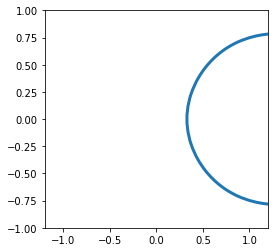

In [18]:
def getH(x,y):
    z = x+1j*y
    U = z/np.sqrt(1-z*z)*np.arcsin(z)
    U = U.real
    return 0.5*(x*x+y*y) + 0.4*U

def getI(x,y):
    z = x+1j*y
    W = 2*x/np.sqrt(1-z*z)*np.arcsin(z)
    W = W.real
    return x*x + 0.4*W

def I2Hobj(x):
    measI = getI(x[0],x[1])
    measH = getH(x[0],x[1])
    return (measI-2*measH)**2

from scipy.optimize import minimize
arc = []
for i in range(64):
    x = 0.65*np.random.rand() + 0.35
    y = np.sqrt(2*(x-0.35))
    result = minimize(I2Hobj,[0.4+0.02*i,0.01+0.04*i],tol=1.0e-10)
    if result.x[1] > 1.0e-4 and result.fun < 1.0e-16:        
        arc.append(result.x)
        
arc = np.array(arc)
arc = np.sort(arc,axis=0)
arc2 = arc[::-1,:].copy()
arc2[:,1] = -arc2[:,1]
n=len(arc)
arc3 = np.zeros([2*n,2])
arc3[n:,:] =arc
arc3[:n,:] =arc2
arc2 = None
arc = arc3
arc3 = None

plt.figure(figsize=(4,4))
plt.plot(arc[:,0],arc[:,1],lw=3)
plt.xlim(-1.2,1.2)
plt.ylim(-1,1)

In [ ]:
if len(NU)==1:
    deco = 'nu='+str(NU[0])+'.tau=0.4.mu='
    n = 1024
    fig = plt.figure(figsize=[6.4*0.78,12*0.75])
    cmap = [0]*10
    for i in range(5):
        mu=MU[i]
        plt.subplot(5,2,1+2*i)
        cmap[2*i]=plt.scatter(data[deco+str(mu)]['X'][n],data[deco+str(mu)]['Y'][n],c=data[deco+str(mu)]['c'][n],s=1.0,marker='s')
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        plt.plot(arc[:,0], arc[:,1],'r',lw=2)
        if i==4:
            plt.xticks([-1,0,1])
        else:
            plt.xticks([])
        plt.yticks([-1,0,1])
        plt.xlim(-0.98*1.1,0.98*1.1)
        plt.ylim(-0.98*1.1,0.98*1.1)
        if i==4:
            plt.xlabel('$x_n$')  
        plt.ylabel('$y_n$')
        plt.colorbar(cmap[2*i])

        plt.subplot(5,2,2+2*i)
        cmap[2*i+1]=plt.scatter(data[deco+str(mu)]['X'][-n],data[deco+str(mu)]['Y'][-n],c=data[deco+str(mu)]['c'][-n],s=1.0,marker='s')
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        plt.plot(arc[:,0], arc[:,1],'r',lw=2)
        if i==4:
            plt.xticks([-1,0,1])
        else:
            plt.xticks([])
        plt.yticks([])
        plt.xlim(-0.98*1.1,0.98*1.1)
        plt.ylim(-0.98*1.1,0.98*1.1)
        if i==4:
            plt.xlabel('$x_n$')  
        plt.colorbar(cmap[2*i+1])

    plt.tight_layout()
    plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.0-0.04.turn=1024.png',dpi=270)
    plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.0-0.04.turn=1024.eps',dpi=270)

In [ ]:
if len(NU)==1:
    deco = 'nu='+str(NU[0])+'.tau=0.4.mu=0.01'
    n = NTURN[0]
    fig = plt.figure(figsize=[6.4*0.75,12*5/5*0.75])
    cmap = [0]*10
    for i in range(5):
        n=NTURN[i]
        plt.subplot(5,2,1+2*i)
        cmap[2*i]=plt.scatter(data[deco]['X'][n],data[deco]['Y'][n],c=data[deco]['c'][n],s=1.0,marker='s')
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        if i==4:
            plt.xticks([-1,0,1])
        else:
            plt.xticks([])
        plt.yticks([-1,0,1])
        plt.xlim(-0.98*1.1,0.98*1.1)
        plt.ylim(-0.98*1.1,0.98*1.1)
        if i==4:
            plt.xlabel('$x_n$')  
        plt.ylabel('$y_n$')
        plt.colorbar(cmap[2*i])

        plt.subplot(5,2,2+2*i)
        cmap[2*i+1]=plt.scatter(data[deco]['X'][-n],data[deco]['Y'][-n],c=data[deco]['c'][-n],s=1.0,marker='s')
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        if i==4:
            plt.xticks([-1,0,1])
        else:
            plt.xticks([])
        plt.yticks([])
        plt.xlim(-0.98*1.1,0.98*1.1)
        plt.ylim(-0.98*1.1,0.98*1.1)
        if i==4:
            plt.xlabel('$x_n$')  
        plt.colorbar(cmap[2*i+1])
    plt.tight_layout()
    plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.01.turn=128-2048.png',dpi=270)
    plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.01.turn=128-2048.eps',dpi=270)

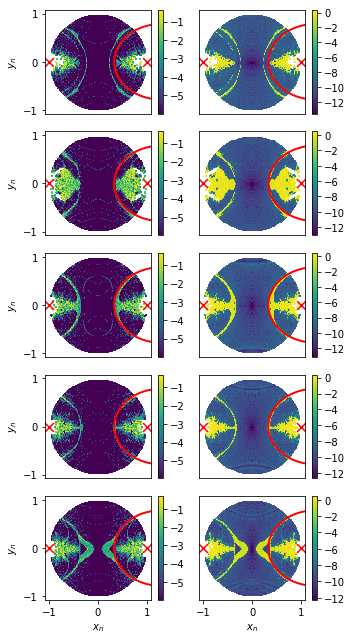

In [66]:
if len(NU)>1:
    n = NTURN[0]
    fig = plt.figure(figsize=[6.4*0.78,12/5*len(NU)*0.75])
    cmap = [0]*len(NU)*2
    for i,nu in enumerate(NU):
        deco = 'nu='+str(nu)+'.tau='+str(TAU[0])+'.mu='+str(MU[0])
        plt.subplot(5,2,1+2*i)
        cmap[2*i]=plt.scatter(data[deco]['X'][n],data[deco]['Y'][n],c=data[deco]['c'][n],s=1.0,marker='s')
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        plt.plot(arc[:,0], arc[:,1],'r',lw=2)
        if i==4:
            plt.xticks([-1,0,1])
        else:
            plt.xticks([])
        plt.yticks([-1,0,1])
        plt.xlim(-0.98*1.1,0.98*1.1)
        plt.ylim(-0.98*1.1,0.98*1.1)
        if i==4:
            plt.xlabel('$x_n$')  
        plt.ylabel('$y_n$')
        plt.colorbar(cmap[2*i])

        plt.subplot(5,2,2+2*i)
        cmap[2*i+1]=plt.scatter(data[deco]['X'][-n],data[deco]['Y'][-n],c=data[deco]['c'][-n],s=1.0,marker='s')
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        plt.plot(arc[:,0], arc[:,1],'r',lw=2)
        if i==4:
            plt.xticks([-1,0,1])
        else:
            plt.xticks([])
        plt.yticks([])
        plt.xlim(-0.98*1.1,0.98*1.1)
        plt.ylim(-0.98*1.1,0.98*1.1)
        if i==4:
            plt.xlabel('$x_n$')  
        plt.colorbar(cmap[2*i+1])

    plt.tight_layout()
    plt.savefig('FMA.FB.nu='+str(NU[0])+'-'+str(NU[-1])+'.mu='+str(MU[0])+'.turn='+str(n)+'.png',dpi=270)
    plt.savefig('FMA.FB.nu='+str(NU[0])+'-'+str(NU[-1])+'.mu='+str(MU[0])+'.turn='+str(n)+'.eps',dpi=270)

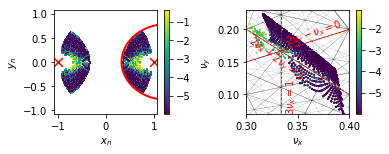

In [19]:
deco = 'nu=0.28.tau=0.4.mu=0.01'

def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy

if deco in data.keys():
    n=NTURN[0]
    X = data[deco]['XF'][2*n]
    Y = data[deco]['YF'][2*n]
    turn,npt = Y.shape
    tuneX = np.zeros(npt)
    tuneY = np.zeros(npt)
    for i in range(npt):
        tuneX[i],amp,dummy = impact.util.naff(1,X[:,i],window_id=1)
        tuneY[i],amp,dummy = impact.util.naff(1,Y[:,i],window_id=1)
    p_nuy0 = np.logical_or(tuneY<0.01, tuneY>0.99)
    xmax = 0.98
    plt.figure(figsize=[6.4*0.86,3.0*0.75])
    plt.subplot(1,2,1)
    f1 = plt.scatter(data[deco]['X'][n][p_nuy0],data[deco]['Y'][n][p_nuy0],c=data[deco]['c'][n][p_nuy0],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    plt.colorbar(f1)
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('$x_n$')
    plt.ylabel('$y_n$')
    
    plt.subplot(1,2,2)
    for i in range(-4,4):
        for j in range(-4,4):
            for k in range(-4,4):
                nux,nuy = resonnace(i,j,k)
                plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)

    for i in range(-6,6):
        for j in range(-6,6):
            for k in range(-6,6):
                nux,nuy = resonnace(i,j,k)
                plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)
                
    r0_in = 0.7
    Arc0yIn = np.linspace(-r0_in,r0_in,100)
    Arc0xIn = -np.sqrt(r0_in**2-Arc0yIn**2)
    x0in_origin = 1.01
    r0_out = 0.7
    Arc0yOut = np.linspace(-r0_out,r0_out,100)
    Arc0xOut = -np.sqrt(r0_out**2-Arc0yOut**2)
    x0out_origin = 1.11
    pInArc = np.logical_and( ((data[deco]['X'][n]-x0in_origin )**2 + data[deco]['Y'][n]**2) > r0_in**2  ,
                             ((data[deco]['X'][n]+x0in_origin )**2 + data[deco]['Y'][n]**2) > r0_in**2  )
                
    f1=plt.scatter(tuneX[pInArc],tuneY[pInArc],c=data[deco]['c'][n][pInArc],s=0.8,marker='o')
    
    nux,nuy = resonnace(3,0,1)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.346, 0.071, r'$3\nu_x=1$', fontsize=10, color='w', rotation=90, rotation_mode='anchor')
    plt.text(0.346, 0.07, r'$3\nu_x=1$', fontsize=10, color='r', rotation=90, rotation_mode='anchor')
    nux,nuy = resonnace(1,2,0)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.34, 0.177, r'$2\nu_y-\nu_x=0$', fontsize=10, color='r', rotation=18.5, rotation_mode='anchor')
    nux,nuy = resonnace(-2,2,1)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.301, 0.181, r'$2\nu_x+2\nu_y=1$', fontsize=10, color='r', rotation=-36.5, rotation_mode='anchor')
    
    plt.xlim(0.3,0.4)
    plt.ylim(0.07,0.23)
    plt.xlabel(r'$\nu_x$')
    plt.ylabel(r'$\nu_y$')
    plt.colorbar(f1)
    
    plt.tight_layout()
    plt.savefig('FMA.DA.nu_y=0.tunefoot.regionI.nu=0.28.tau=0.4.mu=0.01.png',dpi=180)
    plt.savefig('FMA.DA.nu_y=0.tunefoot.regionI.nu=0.28.tau=0.4.mu=0.01.eps',dpi=180)

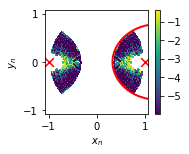

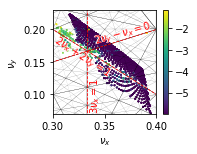

In [37]:
deco = 'nu=0.28.tau=0.4.mu=0.01'
if deco in data.keys():
    n=NTURN[0]
    X = data[deco]['XF'][2*n]
    Y = data[deco]['YF'][2*n]
    turn,npt = Y.shape
    tuneX = np.zeros(npt)
    tuneY = np.zeros(npt)
    for i in range(npt):
        tuneX[i],amp,dummy = impact.util.naff(1,X[:,i],window_id=1)
        tuneY[i],amp,dummy = impact.util.naff(1,Y[:,i],window_id=1)
    p_nuy0 = np.logical_or(tuneY<0.01, tuneY>0.99)
    xmax = 0.98
    
    
    
    
    plt.figure(figsize=[6.4*0.78*0.54,3.0*0.75])
    f1 = plt.scatter(data[deco]['X'][n][p_nuy0],data[deco]['Y'][n][p_nuy0],c=data[deco]['c'][n][p_nuy0],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.yticks([-1,0,1])
    plt.xlabel('$x_n$')
    plt.ylabel('$y_n$')
    plt.colorbar(f1)
    
    plt.tight_layout()
    plt.savefig('FMA.DA.nu_y=0.nu=0.28.tau=0.4.mu=0.01.png',dpi=180)
    plt.savefig('FMA.DA.nu_y=0.nu=0.28.tau=0.4.mu=0.01.eps',dpi=180)
    
    
    
    
    
    plt.figure(figsize=[6.4*0.78*0.56,3.0*0.75])
    for i in range(-4,4):
        for j in range(-4,4):
            for k in range(-4,4):
                nux,nuy = resonnace(i,j,k)
                plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)

    for i in range(-6,6):
        for j in range(-6,6):
            for k in range(-6,6):
                nux,nuy = resonnace(i,j,k)
                plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)
                
    r0_in = 0.7
    Arc0yIn = np.linspace(-r0_in,r0_in,100)
    Arc0xIn = -np.sqrt(r0_in**2-Arc0yIn**2)
    x0in_origin = 1.01
    r0_out = 0.7
    Arc0yOut = np.linspace(-r0_out,r0_out,100)
    Arc0xOut = -np.sqrt(r0_out**2-Arc0yOut**2)
    x0out_origin = 1.11
    pInArc = np.logical_and( ((data[deco]['X'][n]-x0in_origin )**2 + data[deco]['Y'][n]**2) > r0_in**2  ,
                             ((data[deco]['X'][n]+x0in_origin )**2 + data[deco]['Y'][n]**2) > r0_in**2  )
                
    f1=plt.scatter(tuneX[pInArc],tuneY[pInArc],c=data[deco]['c'][n][pInArc],s=0.8,marker='o')
    
    nux,nuy = resonnace(3,0,1)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.3435, 0.071, r'$3\nu_x=1$', fontsize=10, color='r', rotation=90, rotation_mode='anchor')
    nux,nuy = resonnace(1,2,0)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.3415, 0.1785, r'$2\nu_y-\nu_x=0$', fontsize=10, color='w', rotation=15.7, rotation_mode='anchor')
    plt.text(0.3415, 0.1775, r'$2\nu_y-\nu_x=0$', fontsize=10, color='w', rotation=15.7, rotation_mode='anchor')
    plt.text(0.3405, 0.1785, r'$2\nu_y-\nu_x=0$', fontsize=10, color='w', rotation=15.7, rotation_mode='anchor')
    plt.text(0.3405, 0.1775, r'$2\nu_y-\nu_x=0$', fontsize=10, color='w', rotation=15.7, rotation_mode='anchor')
    plt.text(0.341 , 0.178 , r'$2\nu_y-\nu_x=0$', fontsize=10, color='r', rotation=15.7, rotation_mode='anchor')
    nux,nuy = resonnace(-2,2,1)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.3015, 0.1825, r'$2\nu_x+2\nu_y=1$', fontsize=10, color='w', rotation=-33, rotation_mode='anchor')
    plt.text(0.3015, 0.1815, r'$2\nu_x+2\nu_y=1$', fontsize=10, color='w', rotation=-33, rotation_mode='anchor')
    plt.text(0.3005, 0.1825, r'$2\nu_x+2\nu_y=1$', fontsize=10, color='w', rotation=-33, rotation_mode='anchor')
    plt.text(0.3005, 0.1815, r'$2\nu_x+2\nu_y=1$', fontsize=10, color='w', rotation=-33, rotation_mode='anchor')
    plt.text(0.301 , 0.182 , r'$2\nu_x+2\nu_y=1$', fontsize=10, color='r', rotation=-33, rotation_mode='anchor')
    
    plt.xlim(0.3,0.4)
    plt.ylim(0.07,0.23)
    plt.xlabel(r'$\nu_x$')
    plt.ylabel(r'$\nu_y$')
    plt.colorbar(f1)
    
    plt.tight_layout()
    plt.savefig('FMA.tunefoot.regionI.nu=0.28.tau=0.4.mu=0.01.png',dpi=180)
    plt.savefig('FMA.tunefoot.regionI.nu=0.28.tau=0.4.mu=0.01.eps',dpi=180)

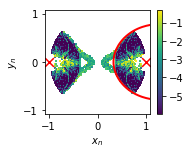

In [80]:
deco = 'nu=0.36.tau=0.4.mu=0.01'
if deco in data.keys():
    xmax = 0.98
    n=NTURN[0]
    X = data[deco]['XF'][2*n]
    Y = data[deco]['YF'][2*n]
    turn,npt = Y.shape
    tuneY = np.zeros(npt)
    for i in range(npt):
        tuneY[i],amp,dummy = impact.util.naff(1,Y[:,i],window_id=1)
    p_nuy0 = np.logical_or(tuneY<0.01, tuneY>0.99)
    xmax = 0.98
    plt.figure(figsize=[3.2*0.85,3.0*0.75])
    f1 = plt.scatter(data[deco]['X'][n][p_nuy0],data[deco]['Y'][n][p_nuy0],c=data[deco]['c'][n][p_nuy0],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    plt.colorbar(f1)
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.yticks([-1,0,1])
    plt.xlabel('$x_n$')
    plt.ylabel('$y_n$')
    plt.tight_layout()
    plt.savefig('FMA.DA.nu_y=0.nu=0.36.tau=0.4.mu=0.01.png',dpi=180)
    plt.savefig('FMA.DA.nu_y=0.nu=0.36.tau=0.4.mu=0.01.eps',dpi=180)

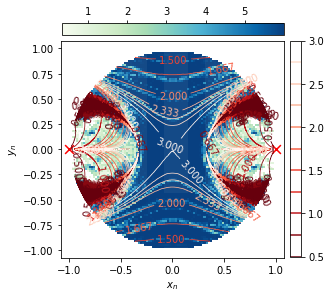

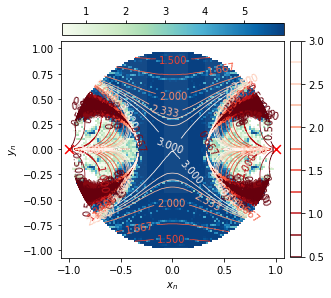

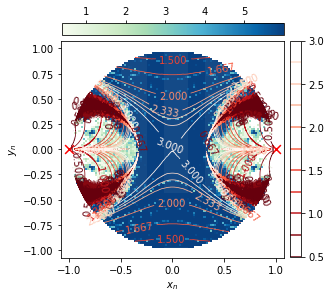

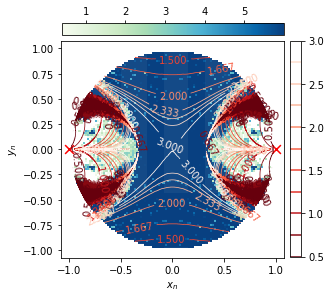

In [95]:
deco = 'nu=0.3.tau=0.4.mu=0.01'
if deco in data.keys():
    class nf(float):
        def __repr__(self):
            s = f'{self:.1f}'
            return f'{self:.0f}' if s[-1] == '0' else s
    xmax = 0.98
    tuneData = pickle.load(open('tuneContourData','rb'))
    for n in NTURN[1:]:
        fig = plt.figure(figsize=[4,4])
        f1=plt.scatter(data[deco]['X'][n],data[deco]['Y'][n],c=-data[deco]['c'][n],s=2.0,marker='s',cmap='GnBu')
        f2=plt.tricontour(tuneData['X0'],tuneData['Y0'],tuneData['nu_x']/tuneData['nu_y'],
                      levels=[0.02,1/3,1/2,2/3,1,4/3,3/2,5/3,2,7/3,5/2,8/3,3],
                      cmap = 'Reds_r')
        f2.levels = [nf(val) for val in f2.levels]
        plt.clabel(f2, f2.levels, fontsize=10)
        plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
        plt.xlim(-xmax*1.1,xmax*1.1)
        plt.ylim(-xmax*1.1,xmax*1.1)
        plt.xlabel('$x_n$')
        plt.ylabel('$y_n$')
        cax1 = fig.add_axes([0.13, 0.9, 0.77, 0.04])
        cb1 = plt.colorbar(f1,orientation='horizontal', cax=cax1)
        cax1.xaxis.set_label_position('top')
        cax1.xaxis.set_ticks_position('top')
        plt.setp(f2.collections , linewidth=0.75)
        cax2 = fig.add_axes([0.92, 0.13, 0.04, 0.75])
        plt.colorbar(f2,drawedges=False, cax=cax2)
        plt.savefig('FMA.DA_tune.nux_nuy.nu=0.3.tau=0.4.mu=0.01.turn='+str(int(n/2))+'.png',
                    dpi=180, bbox_inches = "tight")
        plt.savefig('FMA.DA_tune.nux_nuy.nu=0.3.tau=0.4.mu=0.01.turn='+str(int(n/2))+'.eps',
                    dpi=180, bbox_inches = "tight")